# 시작

In [39]:
import os, glob

import cv2
import matplotlib.pyplot as pyplot
import numpy

import dlib

# 사진 불러오기 함수

In [40]:
def load_image(image_path):
    '''
    image_path : 불러올 사진의 위치
    
    return     : 사진 데이터, BGR형태로 반환
    '''
    raw_image_bgr = cv2.imread(image_path)
    
    # 제대로 불러왔는지 그려본다
    pyplot.imshow(cv2.cvtColor(raw_image_bgr, cv2.COLOR_BGR2RGB))
    pyplot.show()
    
    return raw_image_bgr

# 얼굴의 위치 찾는 함수

In [41]:
def find_hog_rect(image):
    '''
    image : 얼굴을 찾을 사진 데이터
    
    return : 얼굴 위치의 사각형 리스트, 얼굴이 n개인 경우 리스트의 크기는 n
    '''
    hog_image = image.copy()
    hog_detector = dlib.get_frontal_face_detector()
    detected_rects = hog_detector(hog_image, 1)
    
    # 제대로 찾았는지 그려본다
    for r in detected_rects:
        cv2.rectangle(hog_image, (r.left(), r.top()), (r.right(), r.bottom()), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    pyplot.imshow(cv2.cvtColor(hog_image, cv2.COLOR_BGR2RGB))
    pyplot.show()
    
    return detected_rects

# 얼굴의 특징점 찾는 함수

In [42]:
def find_landmarks(image, rects):
    '''
    image : 특징점을 찾을 사진 데이터
    rects : 얼굴 위치의 사각형 리스트, 얼굴이 n개인 경우 리스트의 크기는 n, find_hog_rect로 찾은 리스트를 그대로 이용
    
    return : 특징점'들'의 리스트, 사각형 n개인 경우 리스트의 크기는 n
    '''
    landmark_image = image.copy()
    model_path = os.getenv('HOME') + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    predicted_landmarks = []
    for rect in rects:
        points = landmark_predictor(landmark_image, rect)
        predicted_landmarks.append(points.parts())

    # 제대로 찾았는지 그려본다
    for landmark in predicted_landmarks:
        for p in landmark:
            cv2.circle(landmark_image, (p.x, p.y), 2, (0, 0, 255), -1)
    pyplot.imshow(cv2.cvtColor(landmark_image, cv2.COLOR_BGR2RGB))
    pyplot.show()
    
    return predicted_landmarks

# 이미지를 회전시키는 함수, 수염 이미지를 회전 시키기 위해 사용함

In [43]:
def rotate_image(image, angle):
    '''
    image : 회전시킬 이미지
    angle : 회전시킨 각도, degree임에 주의, -180~0~180
    
    return : 회전된 이미지
    '''
    image_center = tuple(numpy.array(image.shape[1::-1]) // 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return rotated_image

# 한 얼굴에 고양이 수염 붙이기 함수

In [44]:
def add_sticker(image, center_x, center_y, width, angle):
    '''
    image    : 얼굴이 있는 사진 데이터
    center_x : 고양이 수염을 붙일 지점 x, 가운데 지점으로 정한다
    center_y : 고양이 수염을 붙일 지점 y, 가운데 지점으로 정한다
    width    : 고양이 수염 이미지의 가로 pixel, 세로는 고양이 수염 이미지의 비율에 따라 계산한다
    angle    : 고양이 수염의 회전 각도
    
    return   : 수염이 붙은 이미지
    '''
    
    # 고양이 이미지를 불러 세로 크기를 계산하고, 회전시킨다
    sticker_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/cat-whiskers.png'
    raw_sticker = cv2.imread(sticker_path,-1)
    height = (width * raw_sticker.shape[1]) // raw_sticker.shape[0]
    resized_sticker = cv2.resize(raw_sticker, (width, height))
    transformed_sticker = rotate_image(resized_sticker, angle)
    
    # 고양이 이미지에 투명 영역을 찾아내어 투명도를 가진 ndarray를 준비한다
    resized_alpha = transformed_sticker[:,:,3]
    alphas = numpy.dstack((resized_alpha, resized_alpha, resized_alpha))
    
    # 스티커 영역을 정한다
    left = center_x - width // 2
    right = left + width
    top = center_y - height // 2
    bottom = top + height
    sticker_area = image[top:bottom, left:right]
    
    # 위에서 만든 투명도 ndarray를 조건식으로 하여 스티커 이미지를 사진위에 합성한다
    image[top:bottom, left:right] = numpy.where(alphas==0, sticker_area, transformed_sticker[:,:,:3]).astype(numpy.uint8)
    
    return image

# 한장의 사진에 스티커 붙이기 함수

In [45]:
def make_image(image, rects, landmarks):
    '''
    image     : 스티커를 붙일 사진 데이터
    rects     : 얼굴 영역 리스트
    landmarks : 특징점'들' 리스트
    '''
    for rect, landmark in zip(rects, landmarks):
        # 자연스런 코의 위치를 계산한다
        center_x = (landmark[30].x + landmark[33].x) // 2
        center_y = (landmark[30].y + landmark[33].y) // 2

        # 0, 16
        # 두 점을 기준으로 얼굴의 기울기를 구한다
        dy = landmark[0].y - landmark[16].y
        dx = landmark[16].x - landmark[0].x
        radian = numpy.arctan2(dy, dx)
        angle = numpy.rad2deg(radian)
        
        # 한 얼굴에 스티커를 붙인다
        add_sticker(image, center_x, center_y, rect.width(), angle)
        
    # 잘 붙었는지 그려본다
    pyplot.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    pyplot.show()

# 시작

/home/ssac5/aiffel/camera_sticker/images/face6.jpg


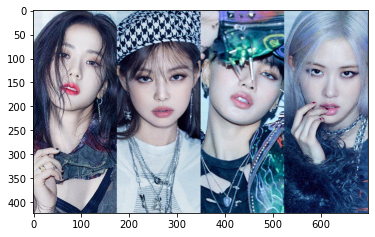

/home/ssac5/aiffel/camera_sticker/images/face4.jpg


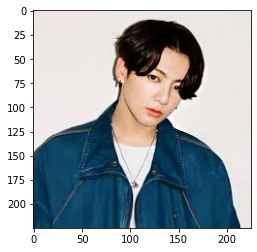

/home/ssac5/aiffel/camera_sticker/images/face7.jpg


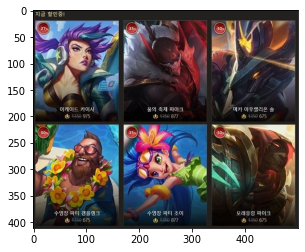

/home/ssac5/aiffel/camera_sticker/images/face3.jpg


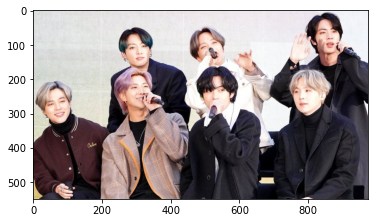

/home/ssac5/aiffel/camera_sticker/images/face1.png


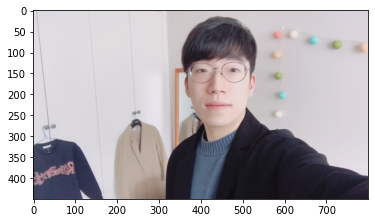

/home/ssac5/aiffel/camera_sticker/images/face2.png


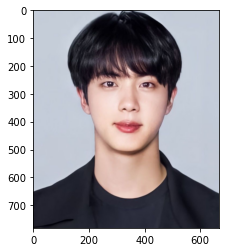

/home/ssac5/aiffel/camera_sticker/images/face5.jpg


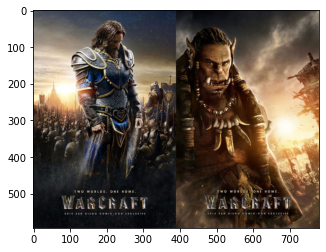

In [46]:
image_dir_path = os.getenv('HOME') + '/aiffel/camera_sticker/images'

# face로 시작하는 모든 파일을 불러온다
image_paths=glob.glob(image_dir_path + '/face*')
images = []
for image_path in image_paths:
    print(image_path)
    image = load_image(image_path)
    images.append(image)

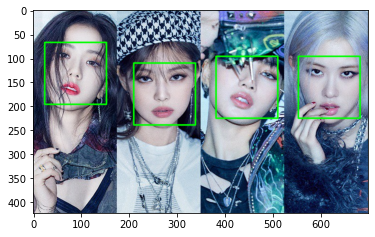

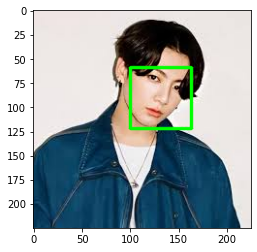

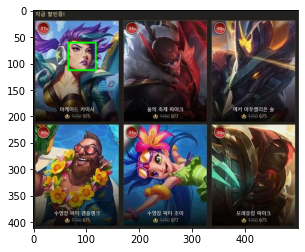

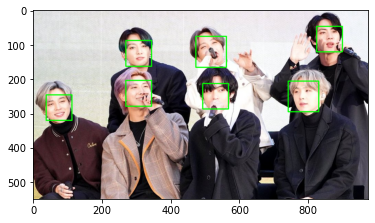

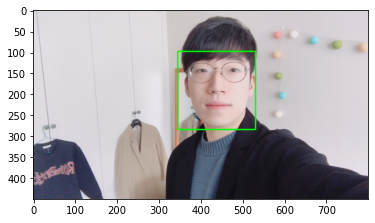

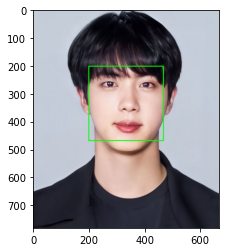

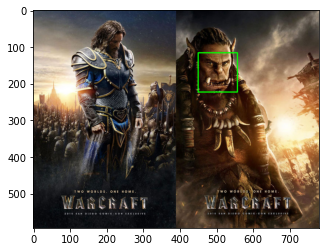

In [47]:
# 각 사진별로 얼굴 영역을 찾는다
found_rects = []
for image in images:
    rects = find_hog_rect(image)
    found_rects.append(rects)

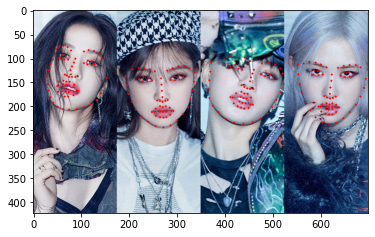

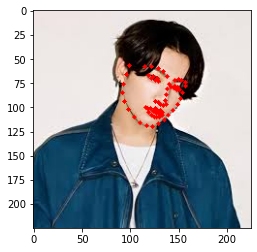

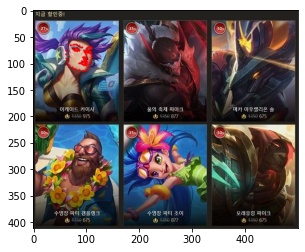

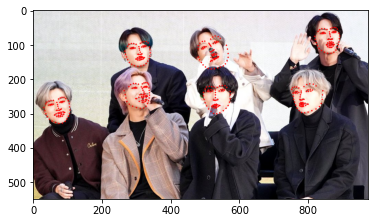

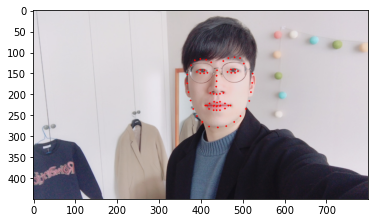

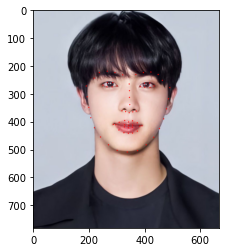

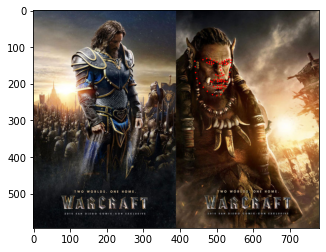

In [48]:
# 각 사진별로 특징점들을 찾는다
found_landmarks = []
for image, rects in zip(images, found_rects):
    landmarks = find_landmarks(image, rects)
    found_landmarks.append(landmarks)

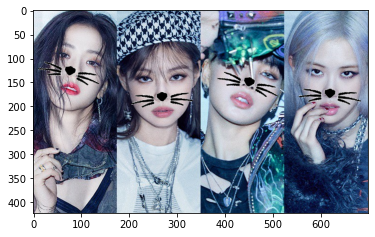

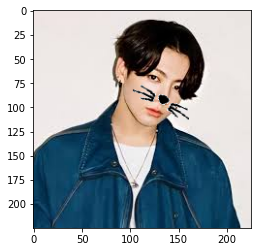

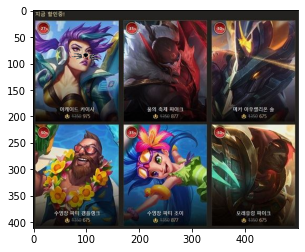

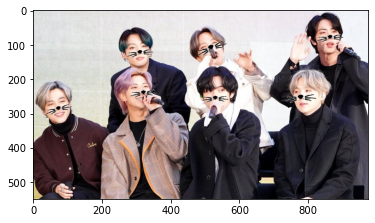

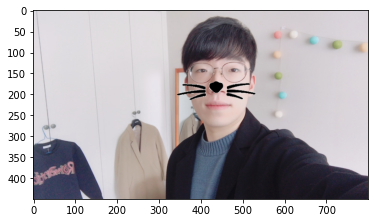

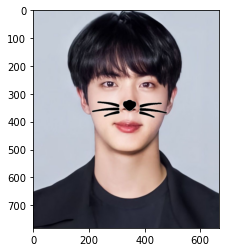

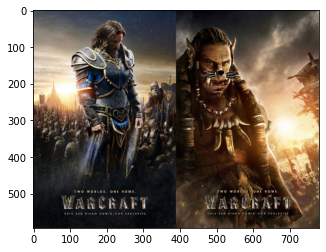

In [49]:
# 사진에 스티커를 붙인다
for image, rects, landmarks in zip(images, found_rects, found_landmarks):
    make_image(image, rects, landmarks)

1. 셀카를 우분투로 옮기가 어려워 인터넷 상의 사진을 다운로드하여 테스트 함
2. numpy의 사용법을 몰라 굉장히 오랜 시간이 걸림. 투명도만 뽑아내어 비교하는 부분이 더 효율적인 방법이 있을 것으로 생각됨
3. 기울기를 통해 수영의 이미지를 회전시켰으나, 원래는 얼굴의 특징점 4개가 만드는 행렬 변형하려고 시도하였고 실패하였음. 그 이유로는 코로부터의 오른쪽과 왼쪽의 거리가 각각 달라지므로 고양이 수염 이미지를 좌우로 분리하여 각각 다른 행렬 변형이 필요한데, 그러기엔 이미지 처리 방법을 잘 모름
4. 여러 사진으로 테스트해 본 결과 사람의 옆면을 추출하는 것은 잘 되지 않음. dlib의 메서드 이름이 get_frontal_face_detector인 것으로 보아 정면 사진만 처리 가능한 것으로 생각됨.
5. 사람처럼 보이는 이미지(게임 이미지)의 경우, 사람과의 유사성에 따라 되기도 하고 안되기도 함.
6. 너무 작은 얼굴을 되지 않음.